# Play with Jupyter and OpenCV
Load an entire page, crop to get only the times & depths, detect all the symbols, and extract the columns of symbols:

In [ ]:
with open("coeffs2023.txt", encoding="utf-8") as f:
  lines = f.readlines()
#print(lines)
rows = []
thisRow = []
for line in lines:
  line = line.strip()
  if line == "":
    rows.append(thisRow)
    thisRow = []
  else:
    thisRow.append(line)

import datetime
date = datetime.datetime(2023, 1, 1, tzinfo=datetime.timezone.utc)
coeffs = []
times = []
while date.year == 2023:
  month = 2 * (date.month - 1)  # Jan = 0, Feb = 2, Mar = 4, etc
  day = date.day - 1
  am = rows[day][month+0]
  pm = rows[day][month+1]
  am = int(am) if am != "-" else None
  pm = int(pm) if pm != "-" else None
  coeffs.append(am)
  coeffs.append(pm)
  times.append(date)
  date = date + datetime.timedelta(hours=12)
  times.append(date)
  date = date + datetime.timedelta(hours=12)

from matplotlib import pyplot as plt, dates as pltdates

days = pltdates.WeekdayLocator(byweekday=pltdates.TU)
fig, ax = plt.subplots(1, figsize=(100, 15))
ax.plot(times, coeffs)
ax.xaxis.set_major_locator(days)
fig.autofmt_xdate()
plt.show()

print(coeffs)


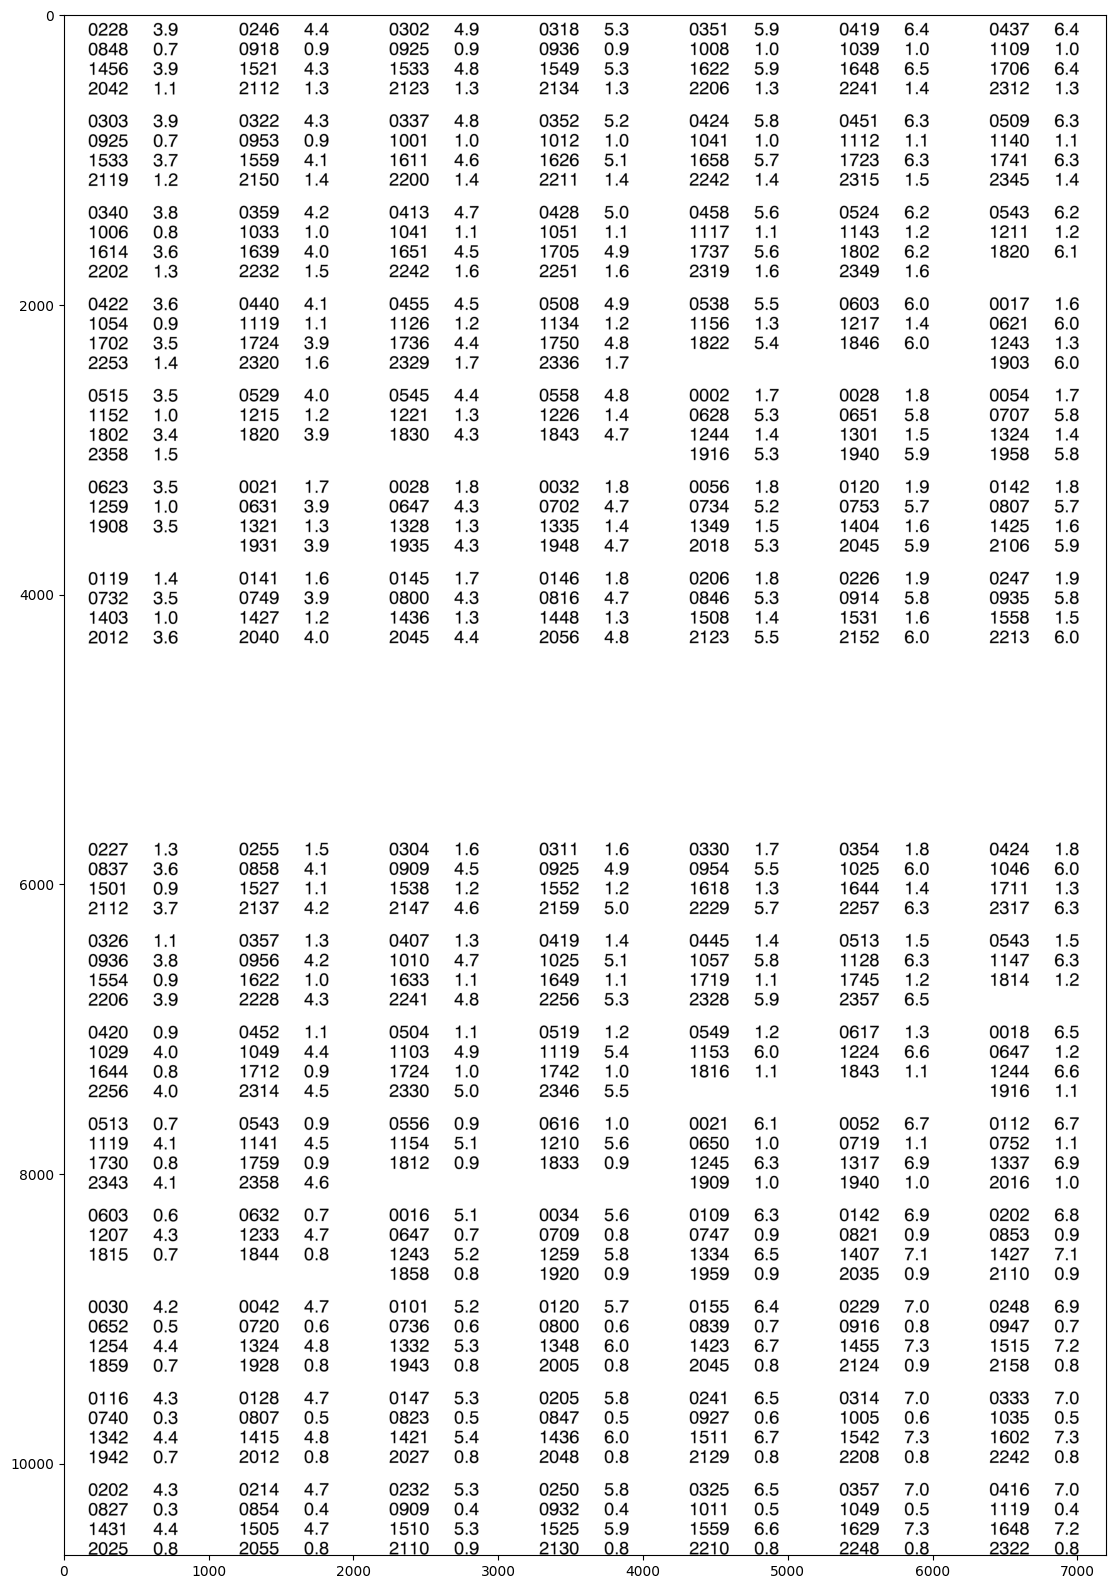

In [1]:
import tide_ocr
from matplotlib import pyplot as plt
cropped = tide_ocr.image_load_crop_fixup("2024/00.png", 900, 1100, 7200)
f = plt.figure(figsize=(20, 20))
plt.imshow(tide_ocr.fix_color(cropped))

In [2]:
import tide_ocr

ocr = dict()

#for i in range(2016, 2022):
#  ocr[i] = tide_ocr.SimpleOCR(str(i), i, 830, 7000, 1100, False, 0, 48)

#ocr[2022] = tide_ocr.SimpleOCR("2022", 2022, 900, 7200, 1470, False, 0, 48)
ocr[2023] = tide_ocr.SimpleOCR("2023", 2023, 900, 7200, 1100, False, 0, 48)
ocr[2024] = tide_ocr.SimpleOCR("2024", 2024, 900, 7200, 1100, True, 0, 24)

We can use OpenCV to extract bounding-boxes for all the symbols on a page, and using the knowledge that each image forms several columns of digits, we can extract a row of symbols and view them.

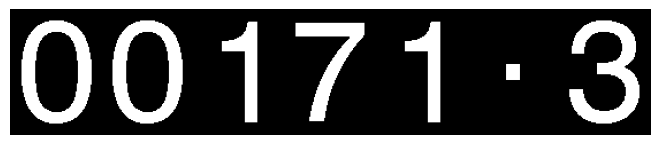

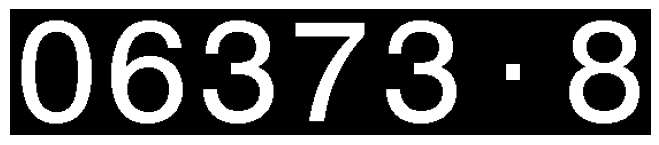

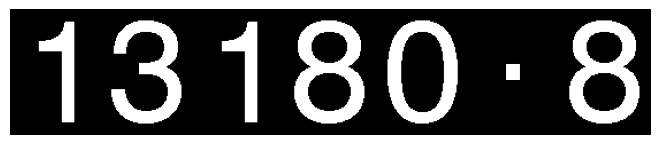

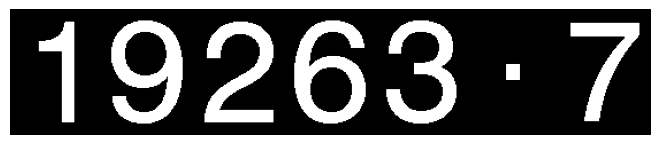

In [3]:
# View the symbols from rows 8, 9, 10 & 11 from the "London Bridge" column on page 20
ocr[2023].display_column("00.png", True, 0, 4, 0)


Now we can read all 48 pages, building up a list of unique symbols. We expect to see only 0-9, "." and "-". This works by maintaining a list of symbols, and xor'ing each new symbol with all the known ones. An xor of two identical symbols will produce an all-black result. An xor of two almost-identical symbols will produce a result with fewer than 30 white pixels. This number 30 is kinda arbitrary. Set it lower and it will find more symbols that it thinks are distinct.

In [4]:
for y in ocr.keys():
  print(y)
  ocr[y].do_ocr()
  print()

2023
    Cumulative analysis of page 0 revealed 11 distinct symbols!
    Cumulative analysis of page 1 revealed 11 distinct symbols!
    Cumulative analysis of page 2 revealed 11 distinct symbols!
    Cumulative analysis of page 3 revealed 11 distinct symbols!
    Cumulative analysis of page 4 revealed 11 distinct symbols!
    Cumulative analysis of page 5 revealed 11 distinct symbols!
    Cumulative analysis of page 6 revealed 11 distinct symbols!
    Cumulative analysis of page 7 revealed 11 distinct symbols!
    Cumulative analysis of page 8 revealed 11 distinct symbols!
    Cumulative analysis of page 9 revealed 11 distinct symbols!
    Cumulative analysis of page 10 revealed 11 distinct symbols!
    Cumulative analysis of page 11 revealed 11 distinct symbols!
    Cumulative analysis of page 12 revealed 11 distinct symbols!
    Cumulative analysis of page 13 revealed 11 distinct symbols!
    Cumulative analysis of page 14 revealed 11 distinct symbols!
    Cumulative analysis of pag

We can view the list of 64 distinct symbols it found. Clearly they are only 0-9, "." and "-", but slightly different (e.g a few pixels shaved off here and there).

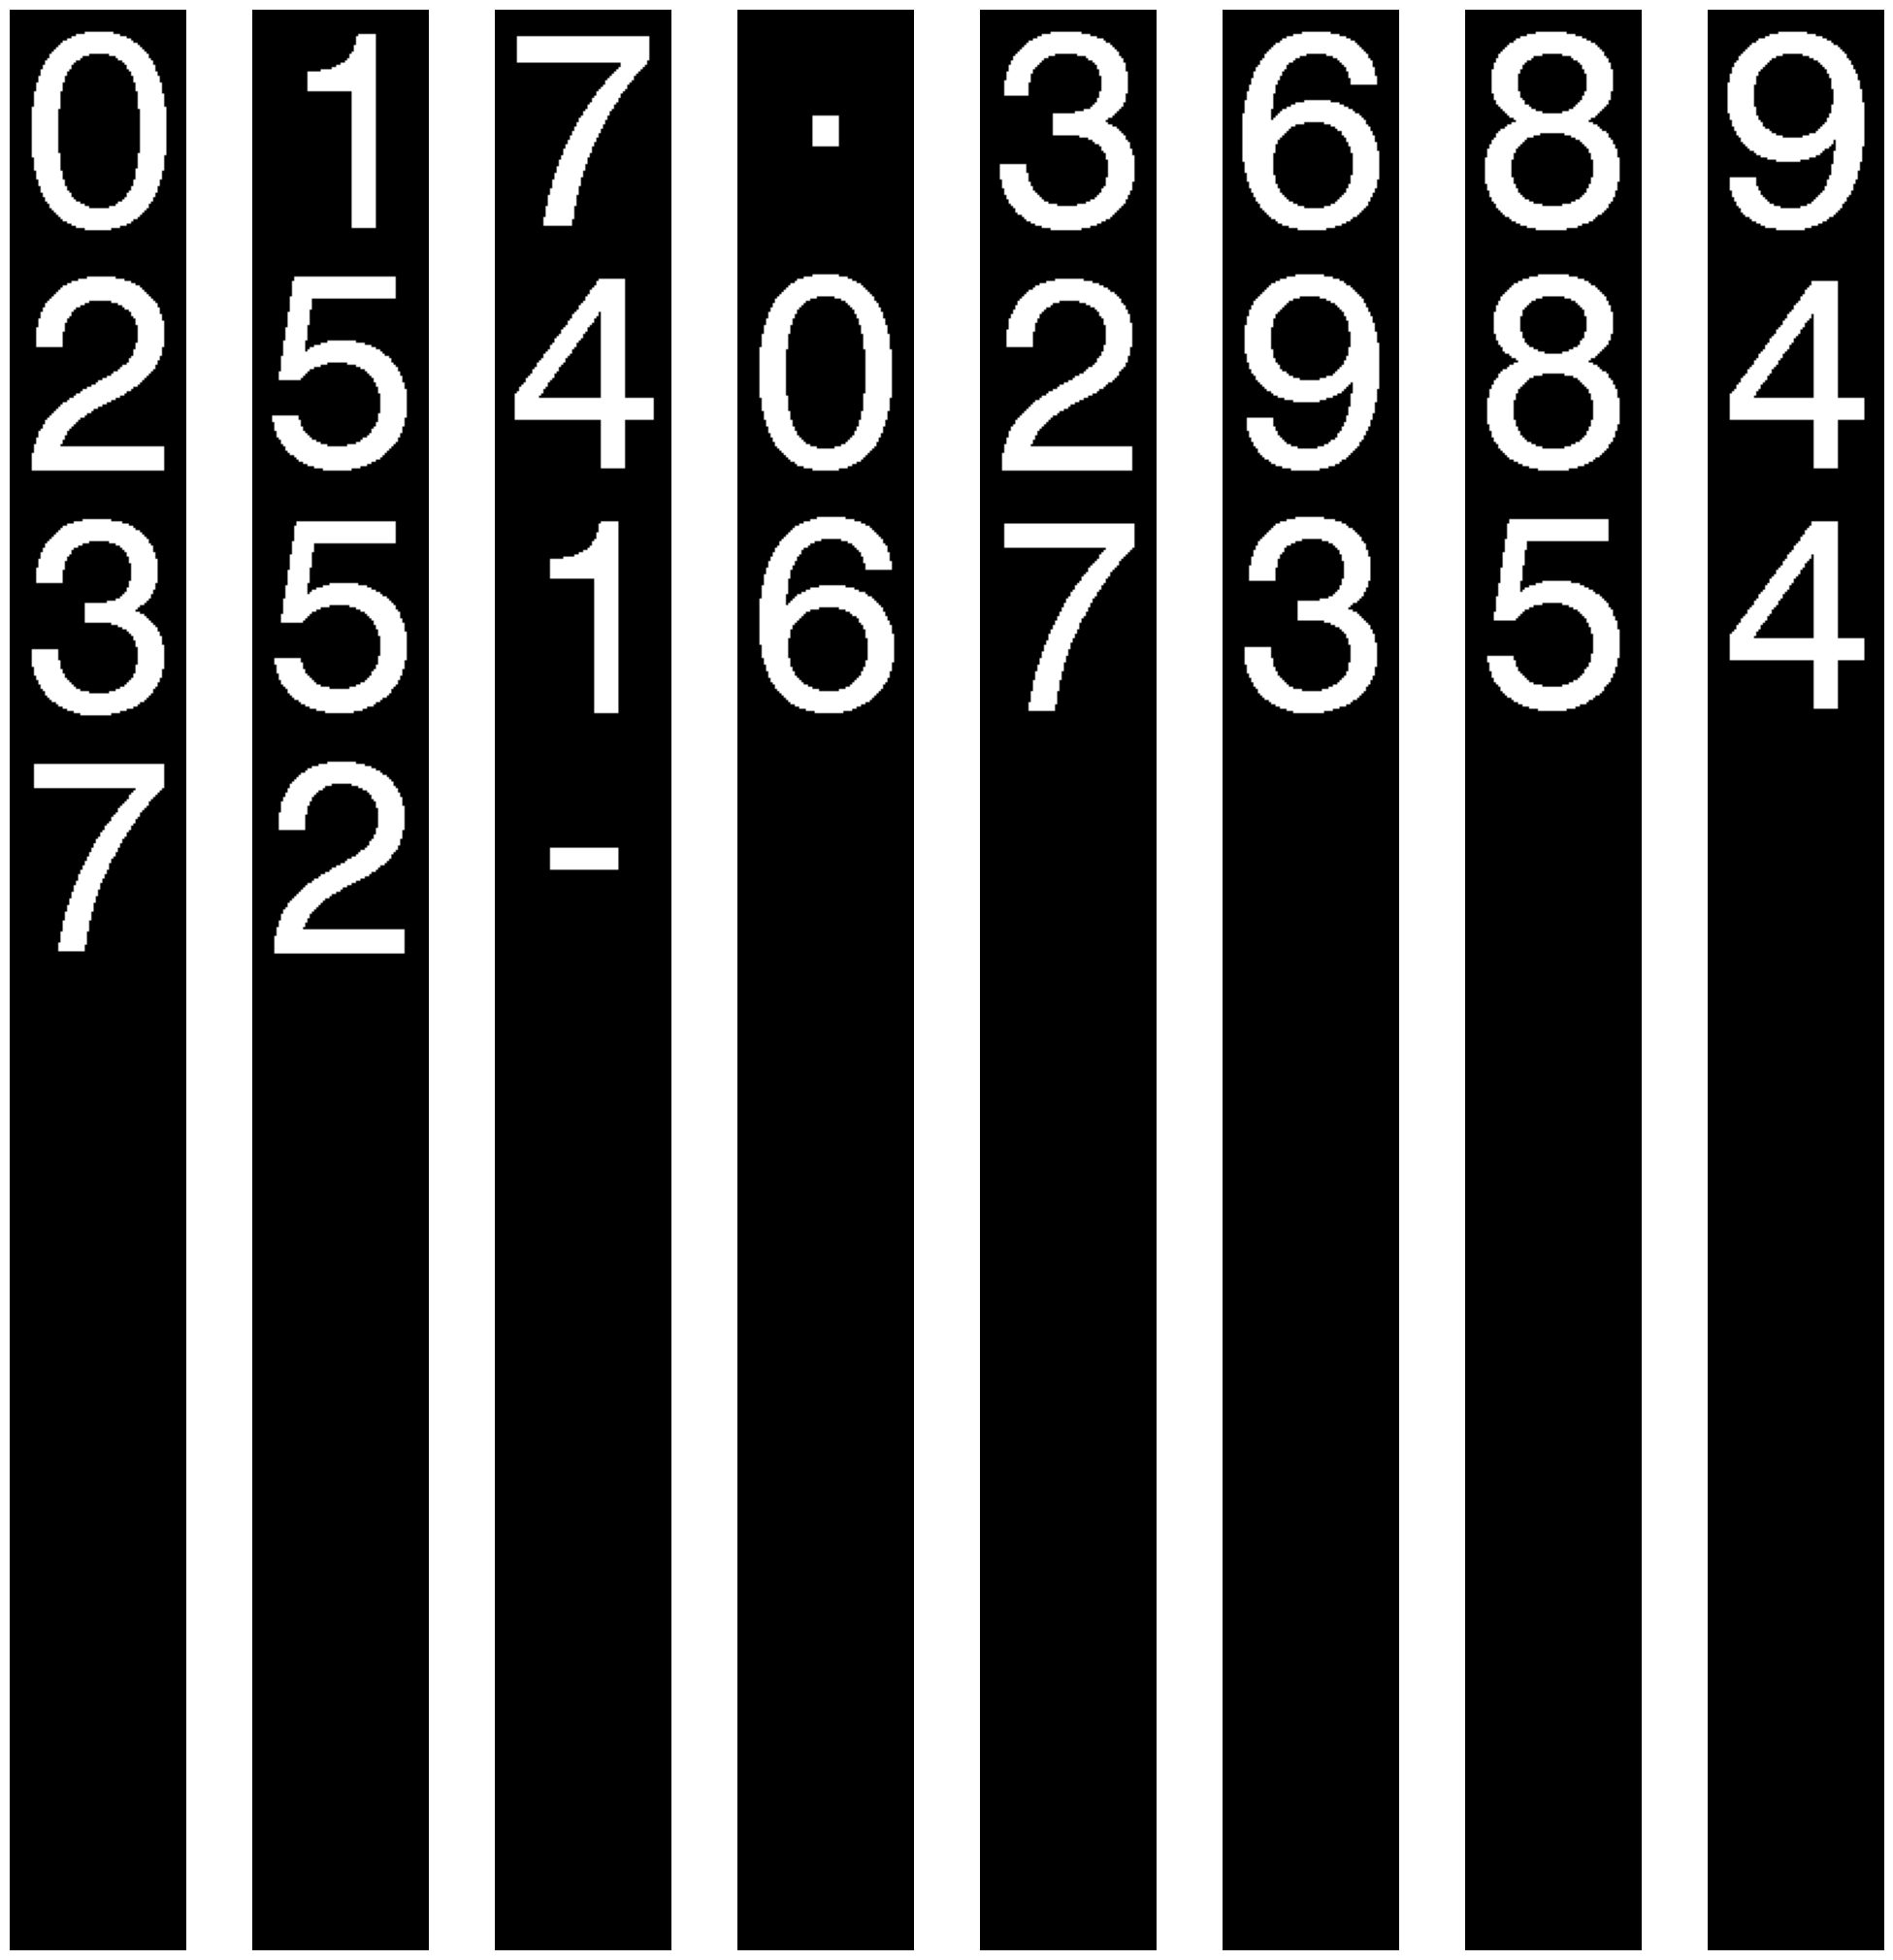

In [5]:
ocr[2023].show_symbols()


Even though the computer thinks there are 64 distinct symbols, there are clearly only 12: digits 0-9, "." and "-". We can visually identify them for the computer, providing a way to actually identify each symbol programmatically, we can parse all the entries in the tide table to get an array of seven columns, each containing ~1400 rows of (date, isDST, HW/LW, height):

In [6]:
from metadata import METADATA
results = dict()
#results[2016] = ocr[2016].parse_all(
#  "0345" + ".896" +
#  "7120" + "3859" +
#  "62"
#)
#results[2017] = ocr[2017].parse_all(
#  "0134" + ".279" +
#  "5869" + "0538" +
#  "6208" + "3628" +
#  "0623" + "9-"
#)
#results[2018] = ocr[2018].parse_all(
#  "0426" + ".138" +
#  "5973" + "0962" +
#  "8-"
#)
#results[2019] = ocr[2019].parse_all(
#  "016." + "7438" +
#  "2598" + "3059" +
#  "26-"
#)
#results[2020] = ocr[2020].parse_all(
#  "034." + "8927" +
#  "1565" + "3602" +
#  "89-"
#)
#results[2021] = ocr[2021].parse_all(
#  "047." + "1658" +
#  "3299" + "8560" +
#  "32"
#)
#results[2022] = ocr[2022].parse_all(
#  "034." + "8956" +
#  "1275" + "2021" +
#  "4073" + "8806" +
#  "3600" + "6913" +
#  "5393" + "6086" +
#  "8599" + "9162" +
#  "2962" + "8899" +
#  "-"
#)
results[2023] = ocr[2023].parse_all(METADATA[2023][6])
results[2024] = ocr[2024].parse_all(METADATA[2024][6])


Now we can get a whole year of data for London Bridge, in human-readable format:

In [7]:
YEAR = 2023
old_date = ""
old_height = 0.0
deltas = []
times = []
old_dt = results[YEAR][2][0][0]
flood = [0] * 12  # 12 time buckets, each 10 mins wide
ebb = [0] * 12
longs = []
for dt, dst, id, h in results[YEAR][2]:
  g = dt - old_dt
  g = int(g.seconds/600)
  #if g != 0:
  #  if id == "HW":
  #    flood[g-32] = flood[g-32] + 1
  #  else:
  #    ebb[g-32] = ebb[g-32] + 1
  old_dt = dt
  d = dt.strftime("%Y-%m-%d:")
  t = dt.strftime("%H%M")
  #if g == 43:
  #  longs.append(d[:-1])
  col1 = d if d != old_date else "           "
  print("{} {} {}{}({}m)".format(col1, id, t, "*" if dst else "", h))
  deltas.append(abs(h-old_height))
  times.append(dt)
  old_date = d
  old_height = h


2023-01-01: LW 0053(1.5m)
            HW 0711(4.7m)
            LW 1351(1.0m)
            HW 2004(4.6m)
2023-01-02: LW 0205(1.5m)
            HW 0819(4.6m)
            LW 1454(1.1m)
            HW 2108(4.6m)
2023-01-03: LW 0313(1.4m)
            HW 0924(4.6m)
            LW 1553(1.2m)
            HW 2207(4.7m)
2023-01-04: LW 0413(1.3m)
            HW 1023(4.7m)
            LW 1644(1.2m)
            HW 2256(4.8m)
2023-01-05: LW 0506(1.1m)
            HW 1113(4.8m)
            LW 1728(1.1m)
            HW 2338(4.8m)
2023-01-06: LW 0553(1.0m)
            HW 1156(4.9m)
            LW 1807(1.1m)
2023-01-07: HW 0014(4.9m)
            LW 0635(0.9m)
            HW 1234(4.9m)
            LW 1843(1.1m)
2023-01-08: HW 0048(5.0m)
            LW 0712(0.9m)
            HW 1309(4.9m)
            LW 1915(1.1m)
2023-01-09: HW 0121(5.0m)
            LW 0746(0.8m)
            HW 1345(4.9m)
            LW 1946(1.1m)
2023-01-10: HW 0155(5.0m)
            LW 0818(0.8m)
            HW 1420(4.9m)
            

We can print the days with unusually long tides:

In [9]:
for tide in longs:
  print(tide)


# import necessary libraries
import pandas as pd
from scipy.signal import find_peaks

# create a sample series
s = pd.Series([1, 3, 2, 4, 3, 5, 4, 6, 5, 4])

# use for loop to find local maxima
local_max_idx, _ = find_peaks(s)
local_max = s[local_max_idx]

# print the results
print(local_max_idx)

[1 3 5 7]


We can plot how the tide range varies from week to week:

In [18]:
from matplotlib import pyplot as plt, dates as pltdates
import datetime

x = []
y = []
old_ord = times[0].toordinal()
sum = 0
count = 0
for t, d in zip(times[1:], deltas[1:]):
  this_ord = t.toordinal()
  if this_ord != old_ord:
    x.append(datetime.datetime.fromordinal(old_ord))
    y.append(sum/count)
    sum = 0
    count = 0
    old_ord = this_ord
  sum = sum + d
  count = count + 1

x.append(datetime.datetime.fromordinal(old_ord))
y.append(sum/count)

days = pltdates.WeekdayLocator(byweekday=pltdates.TU)
fig, ax = plt.subplots(1, figsize=(100, 15))
ax.plot(x, y)
ax.xaxis.set_major_locator(days)
fig.autofmt_xdate()
plt.show()

# create a sample series
s = pd.Series(y)
springs, _ = find_peaks(s)
neaps, _ = find_peaks(-s)
print("Springs:")
for k in springs:
  print(f"  {str(x[k])[:10]}: {y[k]:.3f}")
print("\nNeaps:")
for k in neaps:
  print(f"  {str(x[k])[:10]}: {y[k]:.3f}")

for i, j in zip(x, y):
  print(f"{str(i)[:10]} {j:.2f}")
#for i, j in zip(times[1:], deltas[1:]):
#  print(f"{str(i)[:10]} {j:.2f}")



SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: malformed \N character escape (1717082326.py, line 37)

And we can see the distribution of durations, for flood and ebb:

In [ ]:
import numpy as np

ranges = [
  "5h20-5h29",
  "5h30-5h39",
  "5h40-5h49",
  "5h50-5h59",
  "6h00-6h09",
  "6h10-6h19",
  "6h20-6h29",
  "6h30-6h39",
  "6h40-6h49",
  "6h50-6h59",
  "7h00-7h09",
  "7h10-7h19"
]
fig, ax = plt.subplots(1, figsize=(20, 10))
x_axis = np.arange(len(ranges))
ax.bar(x_axis -0.2, flood, width=0.4, label="Flood")
ax.bar(x_axis +0.2, ebb, width=0.4, label = "Ebb")
plt.xticks(x_axis, ranges)
plt.legend()
plt.show()


Finally, we can look for instances of unusually-low water at London Bridge, and unusually-high water at North Woolwich:

In [ ]:
import datetime

# Render a datetime as a string
def to_str(dt):
  return datetime.datetime.strftime(dt, "%Y-%m-%dT%H:%MZ")

print("Unusually low, at London Bridge:")
for i in results[YEAR][6]:
  if i[3] < 0.1:
    print(f"  {to_str(i[0])}")

print("\nUnusually high, at North Woolwich:")
for i in results[YEAR][5]:
  if i[3] > 7.6:
    print(f"  {to_str(i[0])}")
